In [1]:
from wrapper_functions import *

2023-01-25 23:16:32.832463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which i

TensorFlow version: 2.10.0. Expected: 2.7.0
TensorFlow Probability version: 0.18.0. Expected: 0.15.0


2023-01-25 23:16:50.068549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Experiment II: 2D Spatial Field

### Model Configs

In [2]:
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=10 # @param
mcmc_burnin=2_500 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)


In [3]:
# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = .5 # @param
bma_gp_l2_regularizer = 0.7 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param


In [4]:
# BNE parameters.
bne_gp_lengthscale = .06 # 5. # @param
bne_gp_l2_regularizer = 1. # 15 # @param
bne_variance_prior_mean = -2.5 # @param
bne_skewness_prior_mean = -2.5 # @param
bne_seed = 0 # @param

### Read training/prediction data

In [5]:
training_eastMA = pd.read_csv('./data/training_dataset/training_eastMA.csv')
training_eastMA_noMI = training_eastMA[:51]
training_eastMA_folds = pd.read_csv('./data/training_dataset/training_eastMA_folds.csv')
base_model_predictions_eastMA = pd.read_csv('./data/prediction_dataset/base_model_predictions_eastMA.csv')
display(training_eastMA.shape, training_eastMA_folds.shape, base_model_predictions_eastMA.shape)
print("pred longitude max and min", base_model_predictions_eastMA["lon"].max(),base_model_predictions_eastMA["lon"].min())
print("pred latitude max and min", base_model_predictions_eastMA["lat"].max(),base_model_predictions_eastMA["lat"].min())
#list(base_model_predictions_eastMA.columns)
print("train longitude max and min", training_eastMA["lon"].max(),training_eastMA["lon"].min())
print("train latitude max and min", training_eastMA["lat"].max(),training_eastMA["lat"].min())


training51= pd.read_csv('./data/training_dataset/training51.csv')

FileNotFoundError: [Errno 2] No such file or directory: './data/training_dataset/training_eastMA.csv'

In [ ]:
# standardize
X_train1 = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
X_test1 = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
X_valid = np.concatenate((X_train1, X_test1), axis=0)
X_centr = np.mean(X_valid, axis=0)
X_scale = np.max(X_valid, axis=0) - np.min(X_valid, axis=0)

X_train1 = (X_train1 - X_centr) / X_scale
X_test1 = (X_test1 - X_centr) / X_scale

Y_train = np.expand_dims(training_eastMA_noMI["aqs"], 1).astype(np.float32)
#Y_test = np.expand_dims(base_model_predictions_eastMA["pred_av"], 1).astype(np.float32)

print("2011 center and scale: ", X_centr, X_scale)

In [ ]:
base_model_names = ["pred_av", "pred_gs", "pred_caces"]
base_preds_train = tf.stack([training_eastMA_noMI[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
base_preds_test = tf.stack([base_model_predictions_eastMA[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
#base_preds_test
display(base_preds_train.shape, base_preds_test.shape)

## Bayesian Model Averaging

A Bayesian ensemble model where ensemble weights $w_k's$ are parameterized by Gaussian process priors:

$y \sim N(\mu(x), \sigma^2)$ 

$\mu(x) = \sum_{k=1}^K w_k(x) * m_k(x) \quad$  where $\{m_k\}_{k=1}^K$ are base model predictions.

$w(x) = softmax(f(x)) \qquad\;\;\;$ where $w=[w_1, \dots, w_K]$ and $f=[f_1, \dots, f_K]$

$f \stackrel{i.i.d.}{\sim} GaussianProcess(0, k)$




In [ ]:
# Assemble into configs.
from distutils.log import debug


bma_model_config = DEFAULT_GP_CONFIG.copy()
map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()

bma_model_config.update(dict(lengthscale=bma_gp_lengthscale,
                             l2_regularizer=bma_gp_l2_regularizer,
                             y_noise_std=y_noise_std))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))

mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain))

In [ ]:
display(bma_model_config, map_config, mcmc_config)

### Build model

In [ ]:
bma_prior, bma_gp_config = bma_dist(X_train1, 
                                    base_preds_train, 
                                    **bma_model_config)

bma_model_config.update(bma_gp_config)

# Check if the model graph is specified correctly.
bma_prior.resolve_graph()

In [ ]:
def run_posterior_inference(model_dist: tfd.Distribution, 
                            Y: tf.Tensor, 
                            mcmc_config: Dict[str, Any], 
                            map_config: Optional[Dict[str, Any]] = None, 
                            model_config: Optional[Dict[str, Any]] = None,
                            initialize_from_map: bool = True):
  """Wrapper function for running MCMC with MAP initialization."""
  # Defines posterior log likelihood function, and also a 
  # randomly-sampled initial state from model prior.
  nchain = mcmc_config['nchain']
  init_state, target_log_prob_fn = prepare_mcmc(model_dist, Y, nchain=nchain)  
  
  if initialize_from_map:
    # Initializes at MAP, shape (num_chains, param_shape_0, param_shape_1).
    print('Running MAP:', end='\t')
    init_state = run_map(target_log_prob_fn=target_log_prob_fn, 
                         gp_config=model_config,
                         **map_config)

    init_state = tf.stack([init_state] * mcmc_nchain, axis=0)

  # Run MCMC, shape (param_shape_0, param_shape_1, num_chains).
  print('Running MCMC:', end='\t')
  gp_w_samples, chain_samples, sampler_stat = run_mcmc(init_state=init_state,
                             target_log_prob_fn=target_log_prob_fn,
                             debug_mode=True,
                             **mcmc_config)  
  
  return gp_w_samples, chain_samples, sampler_stat

In [ ]:
# display(bma_model_config, map_config,mcmc_config, bma_prior)

### Run MCMC

In [ ]:
bma_gp_w_samples, chain_samples, sampler_stat = run_posterior_inference(model_dist=bma_prior, 
                                           model_config=bma_model_config,
                                           Y=Y_train, 
                                           map_config=map_config,
                                           mcmc_config=mcmc_config)

# Above the debug mode

# bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior, 
#                                            model_config=bma_model_config,
#                                            Y=Y_train, 
#                                            map_config=map_config,
#                                            mcmc_config=mcmc_config)


bma_joint_samples = make_bma_samples(X_test1, None, base_preds_test, 
                                     bma_weight_samples=bma_gp_w_samples[0],
                                     bma_model_config=bma_model_config,
                                     n_samples=bma_n_samples_eval, 
                                     seed=bne_seed,
                                     y_samples_only=False)



In [ ]:
plt.plot(chain_samples[:, 8, 1011, 2], c='b', alpha=.3)
# plt.title('Traceplot')
# plt.plot(bma_gp_w_samples[1][:,9, 127, 1].numpy(), 'b')
# plt.xlabel('Iteration')
# plt.ylabel('Position')
plt.show()

In [ ]:
#np.mean((means_pred - means_true)**2) / np.var(means_true)
# mse = tf.reduce_mean((means_train_mcmc-Y_train_mcmc)** 2)/ np.var(Y_train_mcmc)
# mse
def rmse(y_obs, y_pred):
    return np.sqrt(np.mean((y_obs - y_pred) ** 2))
bma_mcmc_rmse = rmse(means_train_mcmc, Y_train_mcmc)

reg = LinearRegression().fit(X_train1, Y_train)
y_pred = reg.predict(X_train1)
rmse_lr = mean_squared_error(y_true=Y_train, y_pred=y_pred, squared=False)
display(rmse_lr, bma_mcmc_rmse)

### Prepare Data for BAE/BNE

In [ ]:
# Construct data from BMA samples, shapes (num_samples * num_data, ...)
means_train_mcmc, X_train_mcmc, Y_train_mcmc = make_bma_samples(
    X_train1, Y_train, base_preds_train, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_train,
    seed=bma_seed, 
    prepare_mcmc_training=True)

# Mean samples based on test data, shape (num_samples, num_data, num_output).
# It is used to generate final examples in `make_bne_samples()`.
means_test_mcmc = make_bma_samples(
    X_test1, None, base_preds_test, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_test,
    seed=bma_seed)

In [ ]:
display(means_train_mcmc.shape, X_train_mcmc.shape, Y_train_mcmc.shape, means_test_mcmc.shape)

## Bayesian Additive Ensemble

Given $\mu(x)$ the posterior of a Bayesian ensemble model, the Bayesian Additive Ensemble is defined as:    

$y \sim N(\mu(x) + r(x), \sigma^2)$

$r \sim GaussianProcess(0, k)$

The additive ensemble $r(x)$ services two purposes: 

1. Mitigates systematic bias in model prediction; 
2. Quantifies the model's epistemic uncertainty.

In [ ]:
# # # BNE GP Configs.
# # lengthscale = 1. # @param
# # l2_regularizer = 10. # @param

# BNE model configs. 
# If estimate_mean=False, only estimates a constant variance on top of the 
# original model.
estimate_mean = "True" # @param ["True", "False"]
variance_prior_mean=0. # @param
# # MAP and MCMC configs
# map_step_size=0.1 # @param
# map_num_steps=10_000 # @param

# mcmc_step_size=1e-2 # @param
# mcmc_num_steps=10_000 # @param

bne_gp_config = DEFAULT_GP_CONFIG.copy()
bne_model_config = DEFAULT_BNE_CONFIG.copy()

map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()


bne_gp_config.update(dict(lengthscale=bne_gp_lengthscale, 
                          l2_regularizer=bne_gp_l2_regularizer))
bne_model_config.update(dict(estimate_mean=eval(estimate_mean),
                             variance_prior_mean=variance_prior_mean,
                             **bne_gp_config))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))
mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain))

### Build Model

In [ ]:
# Construct posterior sampler.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')

In [ ]:
display(bne_prior, bne_model_config, map_config, mcmc_config)

### Run MCMC

In [ ]:
# Estimates GP weight posterior using MCMC.
bne_gp_w_samples, chain_samples, sampler_stat = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test1,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

In [ ]:
plt.plot(chain_samples[:, 9, 791, 1], c='b', alpha=.3)
# plt.title('Traceplot')
# plt.plot(bma_gp_w_samples[1][:,9, 127, 1].numpy(), 'b')
# plt.xlabel('Iteration')
# plt.ylabel('Position')
plt.show()

### 10-fold cross validation check

In [9]:
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=10 # @param
mcmc_burnin=2_500 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)


# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = .55 # @param
bma_gp_l2_regularizer = .8 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param


# BNE parameters.
bne_gp_lengthscale = .05 # 5. # @param
bne_gp_l2_regularizer = 1. # 15 # @param
bne_variance_prior_mean = -2.5 # @param
bne_skewness_prior_mean = -2.5 # @param
bne_seed = 0 # @param


# ### Read training/prediction data
training_eastMA = pd.read_csv('../data/training_dataset/training_eastMA.csv')
training_eastMA_noMI = training_eastMA[:51]
training_eastMA_folds = pd.read_csv('../data/training_dataset/training_eastMA_folds.csv')
base_model_predictions_eastMA = pd.read_csv('../data/prediction_dataset/base_model_predictions_eastMA.csv')

print("pred longitude max and min", base_model_predictions_eastMA["lon"].max(),base_model_predictions_eastMA["lon"].min())
print("pred latitude max and min", base_model_predictions_eastMA["lat"].max(),base_model_predictions_eastMA["lat"].min())
#list(base_model_predictions_eastMA.columns)
print("train longitude max and min", training_eastMA["lon"].max(),training_eastMA["lon"].min())
print("train latitude max and min", training_eastMA["lat"].max(),training_eastMA["lat"].min())


training51= pd.read_csv('../data/training_dataset/training51.csv')

# standardize
X_train1 = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
X_test1 = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
X_valid = np.concatenate((X_train1, X_test1), axis=0)
X_centr = np.mean(X_valid, axis=0)
X_scale = np.max(X_valid, axis=0) - np.min(X_valid, axis=0)

X_train1 = (X_train1 - X_centr) / X_scale
X_test1 = (X_test1 - X_centr) / X_scale

Y_train = np.expand_dims(training_eastMA_noMI["aqs"], 1).astype(np.float32)
#Y_test = np.expand_dims(base_model_predictions_eastMA["pred_av"], 1).astype(np.float32)

print("2011 center and scale: ", X_centr, X_scale)


base_model_names = ["pred_av", "pred_gs", "pred_caces"]
base_preds_train = tf.stack([training_eastMA_noMI[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
base_preds_test = tf.stack([base_model_predictions_eastMA[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)


# Assemble into configs.
bma_model_config = DEFAULT_GP_CONFIG.copy()
map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()

bma_model_config.update(dict(lengthscale=bma_gp_lengthscale,
                             l2_regularizer=bma_gp_l2_regularizer,
                             y_noise_std=y_noise_std,
                             #activation='relu',
                             activation_func='none'))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))

mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain,
                       debug_mode=False))

pred longitude max and min -69.93 -73.5
pred latitude max and min 44.3 40.6
train longitude max and min -70.023598 -73.443056
train latitude max and min 44.107524 40.74529
2011 center and scale:  [-72.185104  42.680347] [3.5699997 3.7000008]


In [14]:
kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True) 

rmse_lr = []
rmse_gam = []
rmse_bma = []
nll_lr, nll_gam, nll_bma = [], [], []

coverage_lr = 0
coverage_gam = 0
coverage_bma = 0

import rpy2
#from rpy2.robjects import pandas2ri
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.conversion import localconverter
# import R's "base" package
base = importr('base')
#ms = importr('MSGARCH')
# import R's "utils" package
utils = importr('utils')

with localconverter(ro.default_converter + pandas2ri.converter):
  r_from_pd_df = ro.conversion.py2rpy(training_eastMA_noMI)


mgcv  = importr('mgcv')
stats = importr('stats')
ciTools = importr('ciTools')


#ref_model = LinearRegression()
kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True) 


for train_index, test_index in kf.split(X_train1):
    #print("Train:", train_index, "Validation:",test_index)
    X_tr, X_te = X_train1[train_index], X_train1[test_index] 
    Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

    base_preds_tr, base_preds_te = base_preds_train.numpy()[train_index], base_preds_train.numpy()[test_index]
    print(X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape, base_preds_tr.shape, base_preds_te.shape)

    r_dat_py = training_eastMA_noMI
      
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_tr = ro.conversion.py2rpy(r_dat_py.iloc[train_index])
        r_te = ro.conversion.py2rpy(r_dat_py.iloc[test_index])

    # Ref: lr
    lr_model = stats.lm(ro.Formula('aqs~pred_av+pred_gs+pred_caces'), data=r_tr)
    l = ciTools.add_pi(r_te, lr_model)
    lr_pred = l[7]
    lr_ci_l, lr_ci_u = l[8], l[9]
    coverage_lr += np.sum([(Y_te[i] > lr_ci_l[i]) & (Y_te[i] < lr_ci_u[i]) for i in range(len(Y_te))])
    rmse_lr.append(rmse(Y_te, np.asanyarray(lr_pred).reshape(-1,1)))
    nll_lr.append(nll(Y_te, np.asanyarray(lr_pred).reshape(-1,1)))
    print(rmse_lr)

    # Ref: GAM
    #df = training_eastMA_noMI.iloc[train_index]
    gam_model = mgcv.gam(ro.Formula('aqs ~ s(lon, lat, by=pred_av, k=4) + s(lon, lat,by=pred_gs, k=4) +s(lon, lat, by=pred_caces, k=4)'), data=r_tr)
    a= ciTools.add_pi(r_te, gam_model)
    gam_pred = a[7]
    gam_ci_l, gam_ci_u = a[8], a[9]
    coverage_gam += np.sum([(Y_te[i] > gam_ci_l[i]) & (Y_te[i] < gam_ci_u[i]) for i in range(len(Y_te))])
    rmse_gam.append(rmse(Y_te, np.asanyarray(gam_pred).reshape(-1,1)))
    nll_gam.append(nll(Y_te, np.asanyarray(gam_pred).reshape(-1,1)))
    print(rmse_gam)

    # build model & run MCMC
    fixed_input_tr = tf.ones((X_tr.shape[0], 2), dtype=tf.float32)
    bma_prior, bma_gp_config = bma_dist(fixed_input_tr, 
                                    base_preds_tr, 
                                    **bma_model_config)

    bma_model_config.update(bma_gp_config)


    bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior, 
                                           model_config=bma_model_config,
                                           Y=Y_tr, 
                                           map_config=map_config,
                                           mcmc_config=mcmc_config)

    fixed_input_te = tf.ones((X_te.shape[0], 2), dtype=tf.float32)
    bma_joint_samples = make_bma_samples(fixed_input_te, None, base_preds_te, 
                                     bma_weight_samples=bma_gp_w_samples[0],
                                     bma_model_config=bma_model_config,
                                     n_samples=bma_n_samples_eval, 
                                     seed=bne_seed,
                                     y_samples_only=False)
    y_pred = bma_joint_samples['y']
    y_pred = tf.reduce_mean(y_pred, axis=0)
    pred_std = calc_prediction_std(y_pred, Y_te)
    pred_mean = tf.reduce_mean(y_pred, axis=1)
    bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(), (pred_mean + 1.96*pred_std).numpy()])
    coverage_bma += np.sum([(Y_te[i] > bma_pi[0][i]) & (Y_te[i] < bma_pi[1][i]) for i in range(len(Y_te))])
    rmse_bma.append(rmse(Y_te, y_pred))
    nll_bma.append(nll(Y_te, y_pred))
    print(rmse_bma)
  

print("RMSE LR: ", np.mean(rmse_lr), np.median(rmse_lr), np.std(rmse_lr))
print("RMSE GAM: ", np.mean(rmse_gam), np.median(rmse_gam), np.std(rmse_gam))
print("RMSE BMA: ", np.mean(rmse_bma), np.median(rmse_bma), np.std(rmse_bma))

print("NLL LR: ", np.mean(nll_lr), np.median(nll_lr), np.std(nll_lr))
print("NLL GAM: ", np.mean(nll_gam), np.median(nll_gam), np.std(nll_gam))
print("NLL BMA: ", np.mean(nll_bma), np.median(nll_bma), np.std(nll_bma))

print("Coverage LR: ", coverage_lr/len(Y_train))
print("Coverage GAM: ", coverage_gam/len(Y_train))
print("Coverage BMA: ", coverage_bma/len(Y_train))

lr_s = ['', str(np.mean(rmse_lr)), str(np.std(rmse_lr))]
gam_s = ['', str(np.mean(rmse_gam)), str(np.std(rmse_gam))]
bma_s = [ str(np.mean(rmse_bma)), str(np.std(rmse_bma))]

(45, 2) (6, 2) (45, 1) (6, 1) (45, 3) (6, 3)
[0.4849554265795824]
[0.40761262063818227]
activation function used none
Running MAP:	19138816.0...210555.6875...180847.421875...168461.578125...164052.75...162810.578125...162674.921875...162671.921875...162671.9375...162671.953125...Done.
Running MCMC:	Acceptance Ratio: 0.7304506897926331
activation function used none
[0.5130623]
(46, 2) (5, 2) (46, 1) (5, 1) (46, 3) (5, 3)
[0.4849554265795824, 0.5286288478541905]
[0.40761262063818227, 0.6200543961130601]
activation function used none
Running MAP:	9176773.0...224367.125...169129.15625...162473.828125...161429.671875...161346.09375...161344.9375...161344.921875...161345.0...161344.9375...Done.
Running MCMC:	Acceptance Ratio: 0.6733357906341553
activation function used none
[0.5130623, 0.6134349]
(46, 2) (5, 2) (46, 1) (5, 1) (46, 3) (5, 3)
[0.4849554265795824, 0.5286288478541905, 1.2608314607286146]
[0.40761262063818227, 0.6200543961130601, 1.0748247171645293]
activation function used none


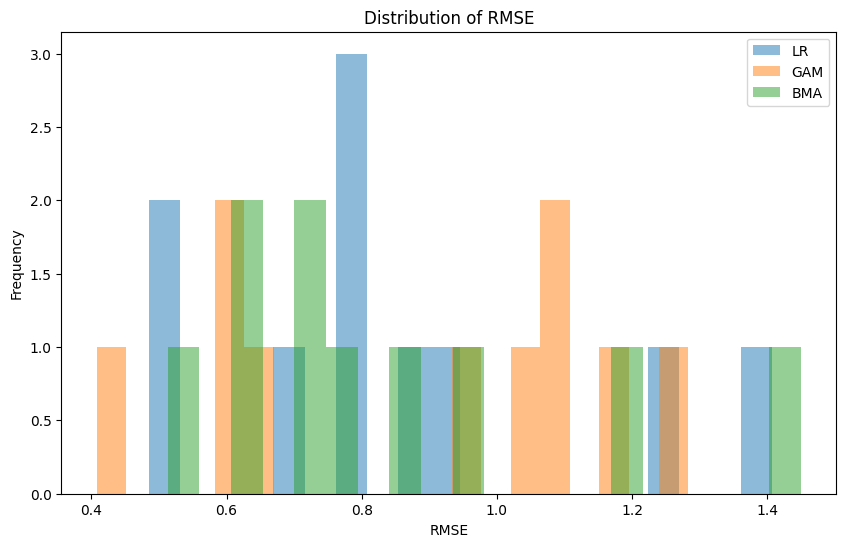

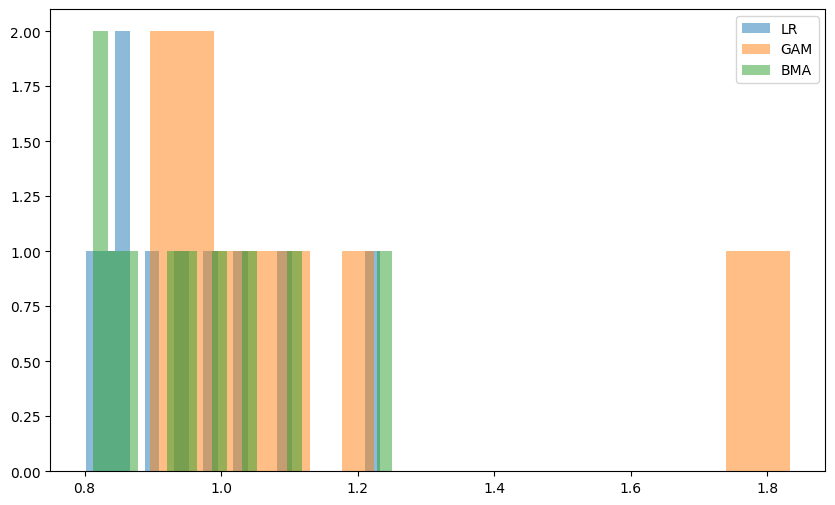

In [15]:
# Plot out distribution of RMSE error to understand why median RMSE << mean RMSE.
plt.figure(figsize=(10, 6))
plt.hist(rmse_lr, bins=20, alpha=0.5, label='LR')
plt.hist(rmse_gam, bins=20, alpha=0.5, label='GAM')
plt.hist(rmse_bma, bins=20, alpha=0.5, label='BMA')
plt.legend(loc='upper right')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Distribution of RMSE')
plt.show()
# Plot out distribution of NLL error to understand why median NLL << mean NLL.
plt.figure(figsize=(10, 6))
plt.hist(nll_lr, bins=20, alpha=0.5, label='LR')
plt.hist(nll_gam, bins=20, alpha=0.5, label='GAM')
plt.hist(nll_bma, bins=20, alpha=0.5, label='BMA')
plt.legend(loc='upper right')
plt.show()